In [78]:
import pandas as pd

# Load the data from the CSV file
data_df = pd.read_csv('siamese.csv')

mean_feature_0 = data_df['feature_0'].mean()
print("Mean of feature_0:", mean_feature_0)

counts = data_df['label'].value_counts()
print("Counts of positive and negative samples:\n", counts)
print(f"ratio of positive to all samples: {counts[1] / counts.sum()}")
data_df.head()

Mean of feature_0: -0.03106577413747691
Counts of positive and negative samples:
 label
0    9462
1    2438
Name: count, dtype: int64
ratio of positive to all samples: 0.20487394957983193


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_6135,feature_6136,feature_6137,feature_6138,feature_6139,feature_6140,feature_6141,feature_6142,feature_6143,label
0,-0.069084,-0.051651,0.027301,-0.025577,-0.014994,-0.044892,0.104467,0.029128,-0.006485,-0.051729,...,-0.048458,-0.007895,0.076936,-0.036059,-0.025765,0.060470,-0.076645,-0.029927,0.019724,0
1,0.092793,-0.031636,-0.018849,0.052498,-0.056464,0.046918,0.088457,0.026677,0.022064,0.019218,...,0.006021,-0.000713,-0.020861,-0.048016,0.007531,0.058048,0.024908,-0.057233,-0.008005,1
2,-0.022626,-0.008029,0.037971,0.011846,-0.035304,0.055649,0.146423,-0.004429,0.012035,0.025177,...,-0.002364,-0.029321,-0.001309,-0.017981,-0.025585,0.106241,0.000243,-0.062140,-0.046487,0
3,-0.069084,-0.051651,0.027301,-0.025577,-0.014994,-0.044892,0.104467,0.029128,-0.006485,-0.051729,...,0.006021,-0.000713,-0.020861,-0.048016,0.007531,0.058048,0.024908,-0.057233,-0.008005,1
4,-0.010722,0.019358,-0.021830,0.014843,-0.070698,0.014798,0.097610,-0.006576,0.049316,0.020525,...,-0.042781,0.021813,-0.049911,-0.109143,0.106317,0.062589,0.115021,0.036450,-0.052912,0


In [79]:
from sklearn.model_selection import train_test_split

EMBEDDING_SIZE = 384
USE_FIRST = 80 * 100

X, Y = data_df.iloc[:, :EMBEDDING_SIZE * 16], data_df['label']
X_train, X_test = X.iloc[:USE_FIRST], X.iloc[USE_FIRST:]
Y_train, Y_test = Y.iloc[:USE_FIRST], Y.iloc[USE_FIRST:]

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8000, 6144), (3900, 6144), (8000,), (3900,))

In [80]:
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import *

word_a = Input(shape=(EMBEDDING_SIZE), name='word_a')
word_b = Input(shape=(EMBEDDING_SIZE), name='word_b')
remaining_words = Input(shape=(EMBEDDING_SIZE * 14), name='remaining_words')

intermediate_model = Sequential(
    [
        Dense(EMBEDDING_SIZE, activation='relu', input_shape=(EMBEDDING_SIZE,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu')
    ]
)

feature_vector_a = intermediate_model(word_a)
feature_vector_b = intermediate_model(word_b)

concat = Concatenate()([feature_vector_a, feature_vector_b, remaining_words])
dense = Dense(512, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[word_a, word_b, remaining_words], outputs=output)
# model.summary()

In [81]:
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

es = EarlyStopping(patience=5)

history = model.fit(x = [X_train.iloc[:, :EMBEDDING_SIZE], 
                         X_train.iloc[:, EMBEDDING_SIZE:EMBEDDING_SIZE*2], 
                         X_train.iloc[:, EMBEDDING_SIZE*2:]],
        y = Y_train,
        validation_data=([X_test.iloc[:, :EMBEDDING_SIZE], 
                          X_test.iloc[:, EMBEDDING_SIZE:EMBEDDING_SIZE*2], 
                          X_test.iloc[:, EMBEDDING_SIZE*2:]], 
                         Y_test),
        epochs=100,
        batch_size=32,
        callbacks=[es])

Epoch 1/100
250/250 [==============================] - 2s 7ms/step - loss: 0.5222 - accuracy: 0.7943 - val_loss: 0.5089 - val_accuracy: 0.7969
Epoch 2/100
250/250 [==============================] - 2s 7ms/step - loss: 0.4856 - accuracy: 0.7944 - val_loss: 0.5189 - val_accuracy: 0.7964
Epoch 3/100
250/250 [==============================] - 2s 8ms/step - loss: 0.4545 - accuracy: 0.7979 - val_loss: 0.5611 - val_accuracy: 0.7569
Epoch 4/100
250/250 [==============================] - 2s 7ms/step - loss: 0.4109 - accuracy: 0.8165 - val_loss: 0.5846 - val_accuracy: 0.7623
Epoch 5/100
250/250 [==============================] - 2s 7ms/step - loss: 0.3440 - accuracy: 0.8501 - val_loss: 0.6495 - val_accuracy: 0.7282
Epoch 6/100
250/250 [==============================] - 2s 7ms/step - loss: 0.2454 - accuracy: 0.9093 - val_loss: 0.6999 - val_accuracy: 0.7723


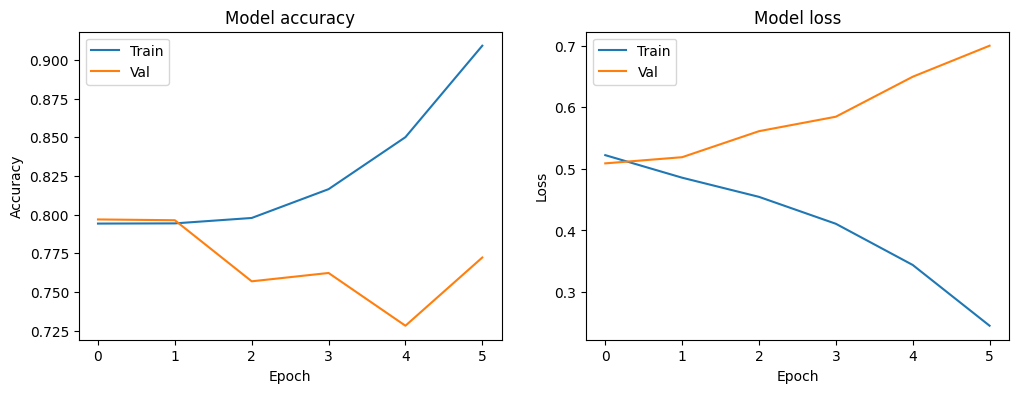

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

122/122 [==============================] - 0s 2ms/step


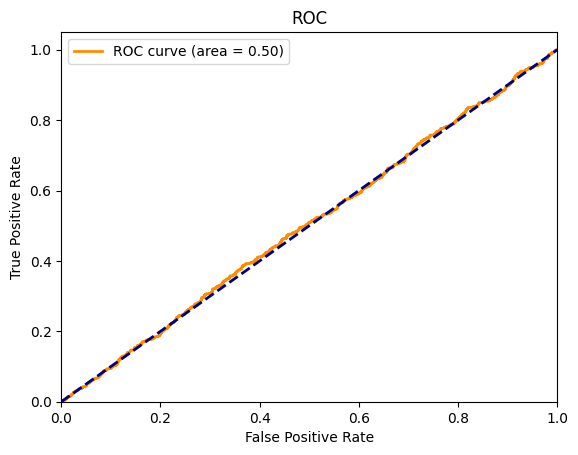

In [83]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Y_pred = model.predict([X_test.iloc[:, :EMBEDDING_SIZE], 
                        X_test.iloc[:, EMBEDDING_SIZE:EMBEDDING_SIZE*2],
                        X_test.iloc[:, EMBEDDING_SIZE*2:]])

fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2 
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()
